# PCA-PRIM on the Hamarat et al. 2014 Model

## Imports

In [1]:
import os
import matplotlib.pyplot as plt

from ema_workbench import load_results
from ema_workbench.analysis.prim import Prim, pca_preprocess

from notebook_helpers.plot_outcomes_lineplot_gaussian import plot_fraction_renewables
from notebook_helpers.clean_hamarat import clean_results
from src.config.paths import HAMARAT_DATA_DIR
from src.config.plot_settings import beautify_plot, apply_global_plot_settings

## Load and Clean Hamarat Model

In [2]:
# Load results
experiments, outcomes = load_results(HAMARAT_DATA_DIR / "10000_lhs_2010_2050.tar.gz")

# Clean data → get X and y
X, y_continuous = clean_results(experiments, outcomes)

 ## Plot the Data and Apply Threshold
 
We first plot the data with the threshold to visualise the fraction of renewables over time, and how the threshold impacts the selected target scenario.

Figure saved: renewables_over_time_0_6_threshold.pdf


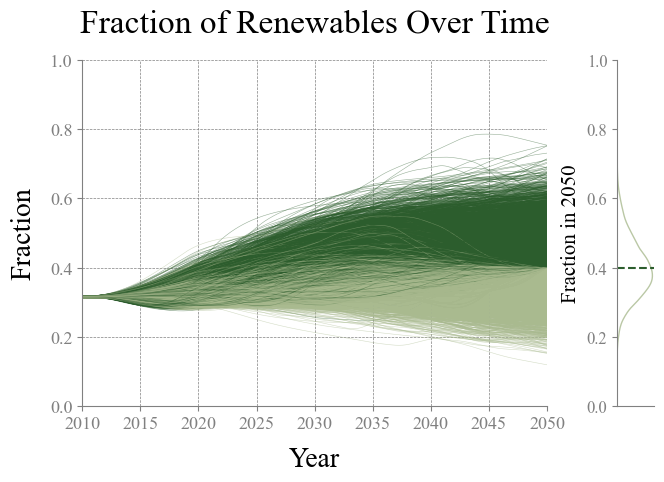


At threshold of 40.0% renewables by 2050:
   → 46.4% of cases exceed threshold (4637 of 10000)
   → 53.6% of cases fall below threshold (5363 of 10000)


In [3]:
plot_fraction_renewables(outcomes, threshold=0.4, save_path="renewables_over_time_0_6_threshold.pdf")

We then apply the threshold to y to create a binary target variable.

In [4]:
threshold_value = 0.4  # for example
y = (y_continuous > threshold_value).astype(int)

## PCA Preprocessing

First we find the categorical variables to exclude them from the pca rotation.

In [5]:
exclude = {col for col in X.columns if X[col].dtype.name in {'category'}}

## Fix for `pca_preprocess` with excluded categorical variables

The original `pca_preprocess` function incorrectly wrote all excluded columns to the same column name in `rotated_experiments` (due to using `name` instead of `entry`).  
To fix this and ensure all excluded categorical variables are preserved correctly, change (around line 156):

```python
for entry in exclude:
    rotated_experiments[name] = experiments[entry]
```

to

```python
for entry in exclude:
    rotated_experiments[entry] = experiments[entry]
```
This ensures that each excluded variable is copied to its own column in rotated_experiments, making the function work as expected when using exclude=... to exclude categorical variables.

In [6]:
rotated_X, rotation_matrix = pca_preprocess(X, y, exclude=exclude)

C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\.venv\Lib\site-packages\ema_workbench\analysis\prim.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  rotation_matrix[j : j + len(value), j : j + len(value)] = subset_rotmat


## Configure PRIM Parameters

In [7]:
# PRIM configuration
mass_min = 0.05        # Minimum fraction of total data required in each valid box
threshold = 0.3        # Required density: only boxes with density >= 0.8 are accepted
peel_alpha = 0.05      # Fraction of mass removed at each peel step (controls peeling speed)
paste_alpha = 0.05     # Fraction of mass added back during pasting (controls pasting sensitivity)

## Set-Up PCA-PRIM

We initialise PCA-PRIM with the *Guivarch update function* (`update_function='guivarch'`), following the approach of Guivarch et al. (2016).  

In [8]:
# Train PRIM
prim_pca = Prim(
    rotated_X,
    y,
    threshold=threshold,
    peel_alpha=peel_alpha,
    paste_alpha=paste_alpha,
    mass_min=mass_min,
    update_function='guivarch',
)

## Finding the First Box
First let us run the algorithm to identify the first box.

In [9]:
box1 = prim_pca.find_box()

### Visualise Coverage-Density Trade-off (First Box)

The trade-off plot visualises candidate boxes found by PRIM along the coverage-density spectrum:

- Each point represents one candidate box evaluated during the peeling and pasting process.
- Moving right increases **coverage** (fraction of target points captured), but often lowers **density** (purity of the box).

This plot is the primary tool for selecting which box to retain.

Figure saved: data\pca_prim\tradeoff_curve.pdf


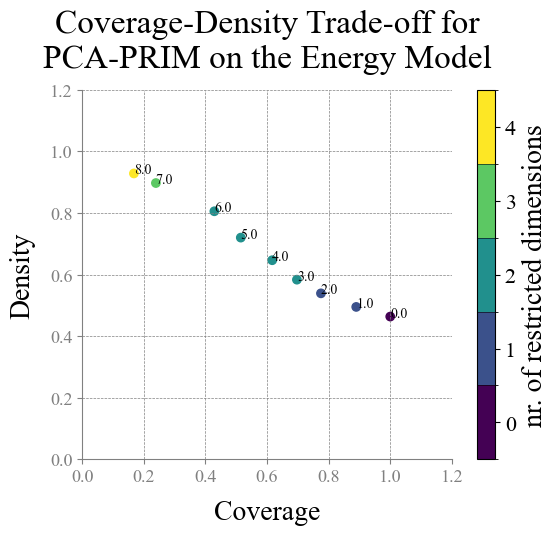

In [10]:
# === Apply global plot settings first ===
apply_global_plot_settings()

# === Now create the PRIM tradeoff plot ===
fig = box1.show_tradeoff(annotated=True)
ax = fig.axes[0]

# === Beautify and save ===
beautify_plot(ax,
              title="Coverage-Density Trade-off for\nPCA-PRIM on the Energy Model",
              xlabel="Coverage",
              ylabel="Density",
              save_path=os.path.join("data", "pca_prim", "tradeoff_curve.pdf"))

### Select First Box

Based on the coverage-density trade-off plot (which looks suspiciously similar to the PRIM one), we see that none of the boxes achieve both high coverage and density. However, we see that either box 4 or 5 is the best box. Both of them use 2 variables to achieve this.

Let us inspect them shortly:


In [11]:
# Show a table of the peeling trajectory
box1.peeling_trajectory

,coverage,density,id,k,mass,mean,n,res_dim
0,1.000000,0.463700,0,4637,1.0000,0.463700,10000,0
1,0.889584,0.495020,1,4125,0.8333,0.495020,8333,1
2,0.775070,0.539154,2,3594,0.6666,0.539154,6666,1
3,0.697002,0.583499,3,3232,0.5539,0.583499,5539,2
4,0.616778,0.646620,4,2860,0.4423,0.646620,4423,2
5,0.514772,0.720060,5,2387,0.3315,0.720060,3315,2
6,0.428941,0.805589,6,1989,0.2469,0.805589,2469,2
7,0.239163,0.897249,7,1109,0.1236,0.897249,1236,3
8,0.167781,0.928401,8,778,0.0838,0.928401,838,4


Box 4 has a coverage of 62% and density of 64%, while box 5 has a coverage of 51% and density of 72% (which is again suspiciously similar to PRIM).

We will select box 5 for its higher density and try to find a second box.

In [12]:
# Box 5 is chosen based on the plot above
best_box_index_1 = 5

### Inspect Selected Box

We now inspect the contents of the selected box (Box 5) in more detail.

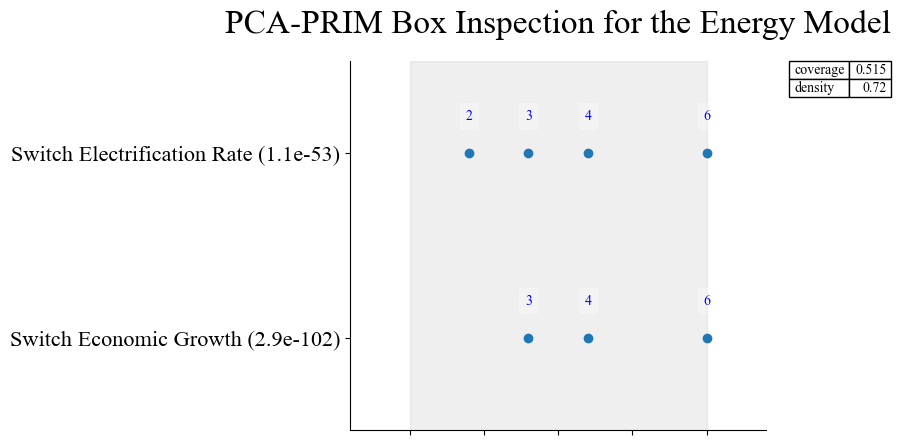

In [13]:
# Show box inspection plot
box1.inspect(best_box_index_1, style="graph")

# Customize the plot
plt.title("PCA-PRIM Box Inspection for the Energy Model", fontsize=24, pad=20)

# Save the plot
save_path_inspect = os.path.join("data", "pca_prim", f"box_{best_box_index_1}_inspection.pdf")
plt.savefig(save_path_inspect, dpi=300, bbox_inches="tight")

plt.show()

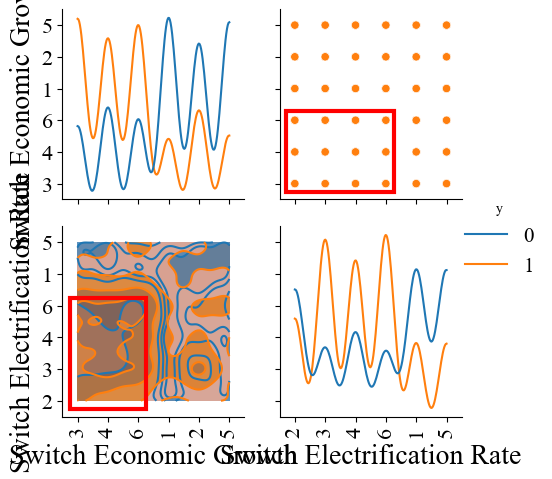

In [14]:
# Show pairwise scatter plot for the best PRIM box
box1.show_pairs_scatter(i=best_box_index_1)
plt.show()

### Interpretation of Selected Box

As visible the selected box is exactly the same as the one identified by prim. 

It again uses 2 categorical variables to try and isolate the cases of interest. The result is that:
- Switch electrification rate with values 2, 3, 4, and 6 are included
- Switch economic growth with values 3, 4, and 6 are included

And this will give a coverage of 51 percent and a density of 72 percent.

## Finding the Second Box

We now run PRIM again to identify a second box.  But, there is no expectation of improved performance based on the current findings.
Because we used the *Guivarch update function*, the first box already excluded the class 1 points it covered.

This means that the second call to `find_box()` will target the remaining class 1 points, in this case, the **bottom-left bell** of the Barbell shape.


In [15]:
# Find second box
box2 = prim_pca.find_box()

### Visualise Coverage-Density Trade-off (Second Box)

We again inspect the coverage-density trade-off to select a suitable box.

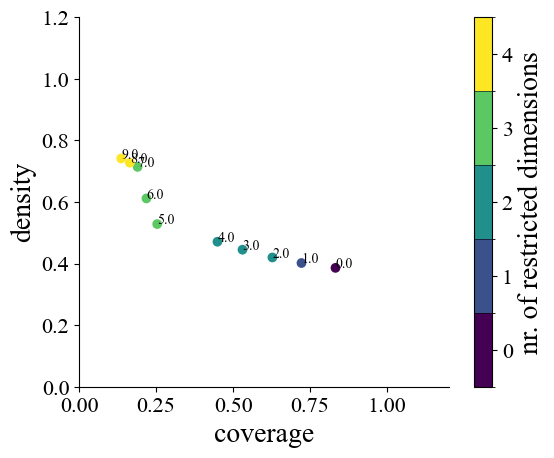

,coverage,density,id,k,mass,mean,n,res_dim
0,0.832219,0.385900,0,3859,1.0000,0.385900,10000,0
1,0.721803,0.401656,1,3347,0.8333,0.401656,8333,1
2,0.627345,0.419709,2,2909,0.6931,0.419709,6931,2
3,0.530300,0.444826,3,2459,0.5528,0.444826,5528,2
4,0.448997,0.470721,4,2082,0.4423,0.470721,4423,2
5,0.253397,0.528090,5,1175,0.2225,0.528090,2225,3
6,0.218460,0.611346,6,1013,0.1657,0.611346,1657,3
7,0.189778,0.713706,7,880,0.1233,0.713706,1233,3
8,0.164546,0.727359,8,763,0.1049,0.727359,1049,4
9,0.136511,0.741218,9,633,0.0854,0.741218,854,4


In [16]:
# Visualize the trade-off between coverage and density for box2
box2.show_tradeoff(annotated=True)
plt.show()

# Show a table of the peeling trajectory
box2.peeling_trajectory

### Select Second Box

Based on the second trade-off plot and the printed list of candidate boxes, we select **Box 6** as the best candidate. With a coverage of 22 percent and a density of 62%.

In [17]:
# Box 37 is chosen based on the plot above
best_box_index_2 = 6

### Inspect Selected Second Box

We next inspect Box 45 from the second PRIM run to verify that it correctly captures the remaining target region.

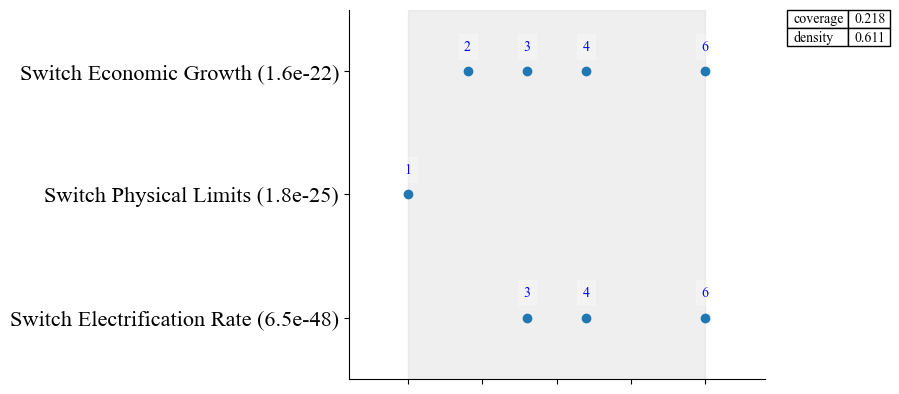

In [18]:
# Show box inspection plot
box2.inspect(best_box_index_2, style="graph")
plt.show()

### Interpretation of Selected Second Box

The selected second box (Box 6) seems to largely overlap with the previously selected boxes. 

We will therefore exclude the PCA-PRIM results from further analysis, as they do not provide additional, let alone better, insights beyond the original PRIM results.